In [1]:
import numpy as np
import numpy.linalg as la
import numpy.random as rnd
np.seterr(all='raise')
import matplotlib.pyplot as plt

In [2]:
data = np.loadtxt("iris.csv", delimiter=",", dtype="object")
matX = data[:,:-1].astype(float).T
lmap = {"Iris-setosa":0, "Iris-versicolor":1, "Iris-virginica":2}
vecY = np.vectorize(lmap.get)(data[:,-1])

In [3]:
vecY1 = np.where(vecY==0, +1, -1)
matX1_1 = matX[:, vecY1==+1]
matX1_2 = matX[:, vecY1==-1]

In [4]:
def calculateMultiDimMean(mat_X):
    multiDimMean = []
    for col in mat_X:
        multiDimMean.append(np.mean(col))
    return np.array(multiDimMean)

In [5]:
mean1_1 = calculateMultiDimMean(matX1_1)
mean1_2 = calculateMultiDimMean(matX1_2)

print("Mean1_1 =", mean1_1)
print("Mean1_2=", mean1_2)

Mean1_1 = [5.006 3.418 1.464 0.244]
Mean1_2= [6.262 2.872 4.906 1.676]


In [6]:
vecY2 = np.where(vecY==2, +1, -1)
matX2_1 = matX[:, vecY2==+1]
matX2_2 = matX[:, vecY2==-1]

In [7]:
mean2_1 = calculateMultiDimMean(matX2_1)
mean2_2 = calculateMultiDimMean(matX2_2)

print("Mean2_1 =", mean2_1)
print("Mean2_2 =", mean2_2)

Mean2_1 = [6.588 2.974 5.552 2.026]
Mean2_2 = [5.471 3.094 2.862 0.785]


In [8]:
def ldaClassifier(matX1, matX2, passedMean1, passedMean2):
    def _calculateSWMatrix(C1, C2):
        return C1 + C2

    def _calculateA(mean1, mean2, SW):
        SWinv = la.inv(SW)
        return SWinv.dot(mean1 - mean2)

    def _calculateX12():
        constantPart = -(var2*mean1 - var1*mean2)/(var1-var2)
        radicantFirstPart = (var2*mean1 - var1*mean2)/(var1 - var2)
        radicantFirstPart = radicantFirstPart * radicantFirstPart
        radicantSecondPart = (var1*mean2*mean2 - var2*mean1*mean1 + 2*var1*var2*np.log((var2/var1)**0.5))/(var1-var2)
        radicant = radicantFirstPart - radicantSecondPart
        x = np.array([constantPart + radicant**0.5, constantPart - radicant**0.5])
        return x

    def _chooseBValue(x):
        if mean1 <= mean2:
            minMean = mean1
            maxMean = mean2
        else:
            minMean = mean2
            maxMean = mean1

        if minMean <= x[0] and x[0] <= maxMean:
            return x[0]
        else:
            return x[1]
    
    CovarianceMat1 = np.cov(matX1)
    CovarianceMat2 = np.cov(matX2)
    
    swMatrix = _calculateSWMatrix(CovarianceMat1, CovarianceMat2)
    a = _calculateA(passedMean1, passedMean2, swMatrix)
    
    mean1 = (a.T).dot(passedMean1)
    var1 = ((a.T).dot(CovarianceMat1)).dot(a)
    mean2 = (a.T).dot(passedMean2)
    var2 = ((a.T).dot(CovarianceMat2)).dot(a)
    
    x = _calculateX12()
    b = _chooseBValue(x)
        
    return a, b

In [9]:
a1, b1 = ldaClassifier(matX1_1, matX1_2, mean1_1, mean1_2)
print("a1 =", a1)
print("b1 =", b1)

a1 = [ 1.34918684  5.31745602 -6.10032312 -1.88621694]
b1 = 6.466552690767639


In [10]:
a2, b2 = ldaClassifier(matX2_1, matX2_2, mean2_1, mean2_2)
print("a2 =", a2)
print("b2 =", b2)

a2 = [-0.43906752  1.04301529  0.50953746  2.68190443]
b2 = 6.778279772459893


In [11]:
def calculateAccuracy(matX, vecY, a, b):
    def sign(x):
        if x <= 0:
            return -1
        else:
            return 1
        
    def f(x):
        return (x.T).dot(a) - b
    
    correct = 0
    wrong = 0
    for x in range(0, len(matX.T)):
        if(sign(f(matX.T[x])) == vecY[x]):
            correct = correct + 1
        else:
            wrong = wrong + 1
    return correct / (correct + wrong)

In [12]:
print("Accuracy erstes Szenario:", calculateAccuracy(matX, vecY1, a1, b1))
print("Accuracy zweites Szenario:", calculateAccuracy(matX, vecY2, a2, b2))

Accuracy erstes Szenario: 1.0
Accuracy zweites Szenario: 0.9266666666666666


Es fällt auf, dass im ersten Szenario alle Trainingsdaten vom Classifier richtig klassifiziert werden.
Beim zweiten Szenario beträgt die Accuracy nur noch 91.33%. Somit kann man davon ausgehen, dass
die "Setosa"-Datenpunkte sich linear von den Datenpunkten der "Versicolor" und "Virginica" separieren lassen.
Andererseits werden sich die Datenpunkte der "Virginica" nicht klar von denen der "Versicolor" trennen lassen,
weshalb keine perfekte Klassifikation möglich ist.

In [13]:
from sklearn.model_selection import train_test_split

In [14]:
def accuracyOfLdaOnSeparatedTestTrainData(matX, vecY):
    x_train, x_test, y_train, y_test = train_test_split(matX.T, vecY, train_size=0.67, test_size=0.33)

    x_train1 = x_train.T[:, y_train==+1]
    x_train2 = x_train.T[:, y_train==-1]

    mean1 = calculateMultiDimMean(x_train1)
    mean2 = calculateMultiDimMean(x_train2)

    a, b = ldaClassifier(x_train1, x_train2, mean1, mean2)
    
    return calculateAccuracy(x_test.T, y_test, a, b)

In [15]:
def calculateAvgAccuracies(n):
    avgAccuracy1 = 0.0;
    avgAccuracy2 = 0.0;
    for i in range(n):
        avgAccuracy1 += accuracyOfLdaOnSeparatedTestTrainData(matX, vecY1)
        avgAccuracy2 += accuracyOfLdaOnSeparatedTestTrainData(matX, vecY2)
    avgAccuracy1 /= n
    avgAccuracy2 /= n
    return avgAccuracy1, avgAccuracy2

avgAccuracy1, avgAccuracy2 = calculateAvgAccuracies(100)

print("Durchschnittliche Accuracy1:", avgAccuracy1)
print("Durchschnittliche Accuracy2:", avgAccuracy2)

Durchschnittliche Accuracy1: 1.0
Durchschnittliche Accuracy2: 0.9206


Wieder ist die zweite Accuracy schlechter und die erste Accuracy perfekt. Dies lässt sich mit der gleichen Erklärung,
wie im Aufgabenteil davor vermutlich auf die Daten zurückführen.

In [16]:
matU, svals, matVt = la.svd(matX)

In [17]:
def showProjection(z):
    y, x = zip(*z.T)
    plt.scatter(x[0:50], y[0:50], c="b", label="Iris-setosa")
    plt.scatter(x[50:100], y[50:100], c="y", label="Iris-versicolor")
    plt.scatter(x[100:150], y[100:150], c="g", label="Iris-virginica")
    plt.legend()
    plt.show()

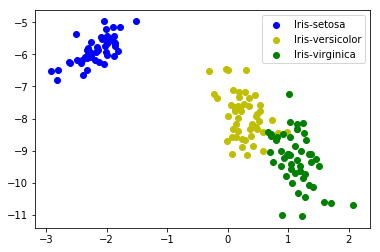

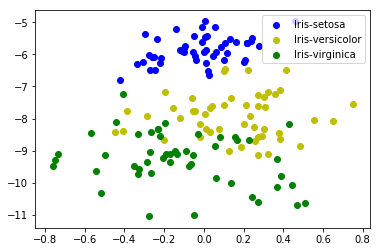

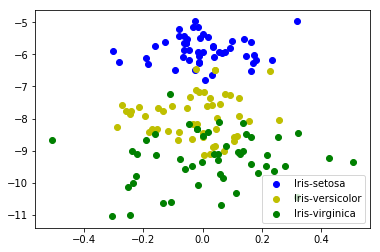

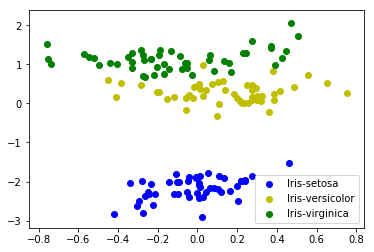

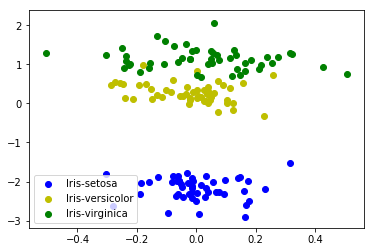

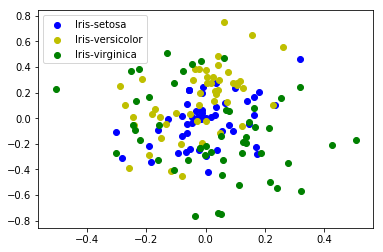

In [18]:
def showAllProjections():
    for i in range(0, 3):
        for j in range(i + 1, 4):
            p = np.array([matU.T[i], matU.T[j]])
            z = p.dot(matX)

            showProjection(z)

showAllProjections()

Wie bereits vorher erwartet bestätigt sich, dass die Datenpunkte von Iris-setosa isoliert von denen von
Iris-versicolor und Iris-virginica vorliegen, wobei die Datenpunkte von Iris-vericolor und Iris-virginica
häufig Überschneidungen aufweisen.